# Self-Organizing Maps on the MNIST dataset

This notebook shows a standard Kohonen SOM (KSOM) and a Dynamic SOM (DSOM) on the MNIST dataset. The MNIST dataset consists of 60k 28x28 grayscale images of figures from 0 to 9. The goal is to project those images on a small 2D map where nearby nodes correspond to nearby images.


In [1]:
%reset -f

import jax
import numpy as np
from matplotlib import pyplot as plt
from array2image import array_to_image

import somap as smp

### Data

Load the MNIST dataset and show the first elements


Shape of dataset: (60000, 28, 28)
Some data samples:


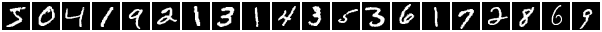

In [2]:
data = smp.datasets.MNIST().data

print(f"Shape of dataset: {data.shape}")
print(f"Some data samples:")

array_to_image(data[:20])

### Model

Initialize the SOM (Kohonon or DSOM):


/tmp/ipykernel_278359/833669581.py:13: UserWarning: Using `field(init=False)` on `equinox.Module` can lead to surprising behaviour when used around `jax.grad`. In the following example, observe how JAX computes gradients with respect to the `.len` attribute (which is a PyTree leaf passed across the `jax.grad` boundary) and that there are no gradients with respect to `.a` or `.b`:

```
import equinox as eqx
import jax
import jax.numpy as jnp

class Foo(eqx.Module):
    a: jax.Array
    b: jax.Array
    len: jax.Array = eqx.field(init=False)

    def __post_init__(self):
        self.len = jnp.sqrt(self.a**2 + self.b**2)

    def __call__(self, x):
        return self.len * x

@jax.jit
@jax.grad
def call(module, x):
    return module(x)

grads = call(Foo(jnp.array(3.0), jnp.array(4.0)), 5)
# Foo(
#   a=Array(0., dtype=float32, weak_type=True),
#   b=Array(0., dtype=float32, weak_type=True),
#   len=Array(5., dtype=float32, weak_type=True)
# )
```
  model = smp.Ksom(shape, topography, bor

Visualisation of the weight values of each node:


alt.LayerChart(...)
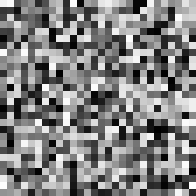
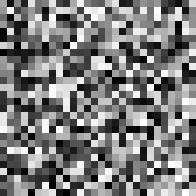
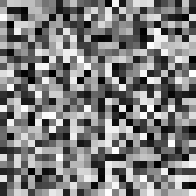
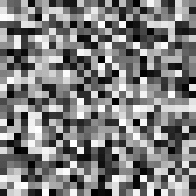
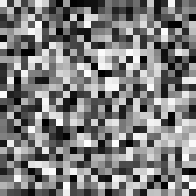
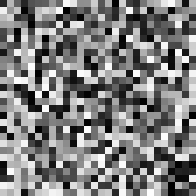
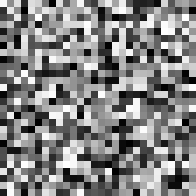
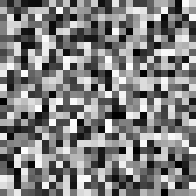
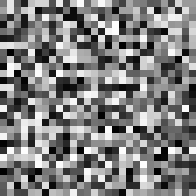
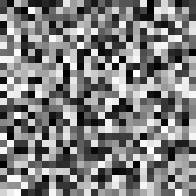
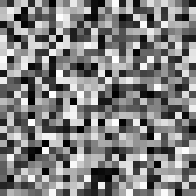
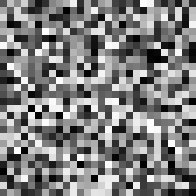
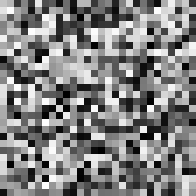
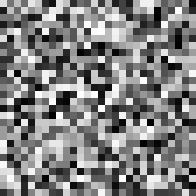
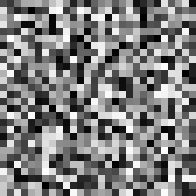
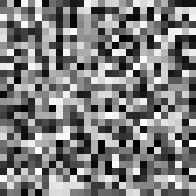
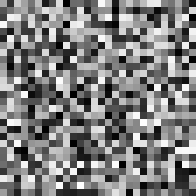
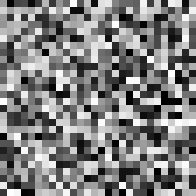
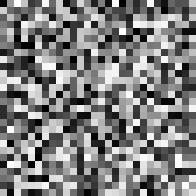
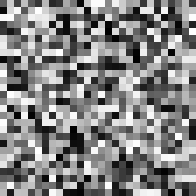
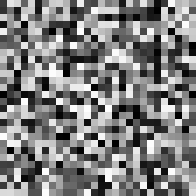
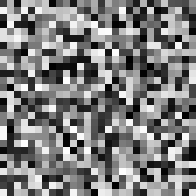
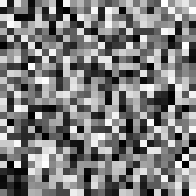
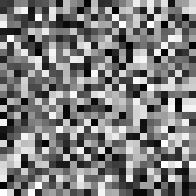
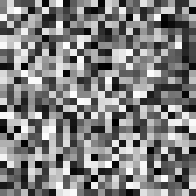
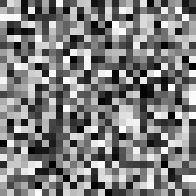
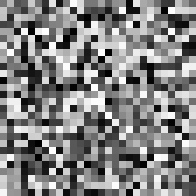
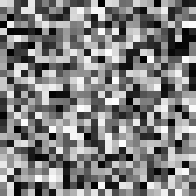
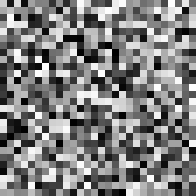
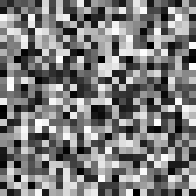
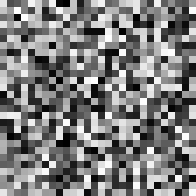
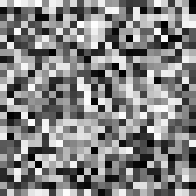
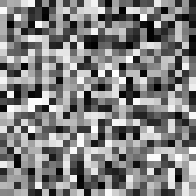
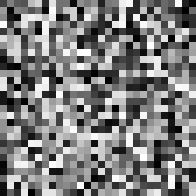
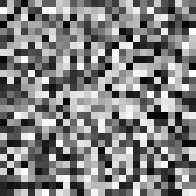
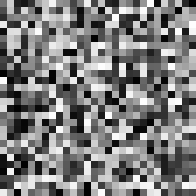
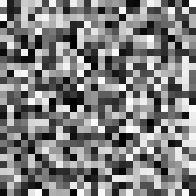
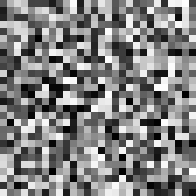
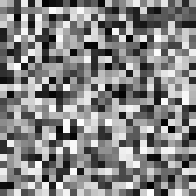
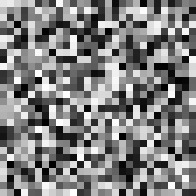
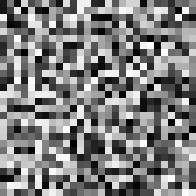
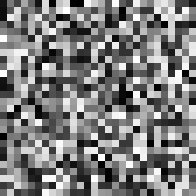
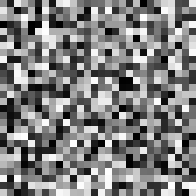
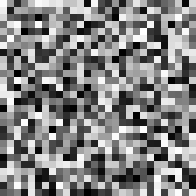
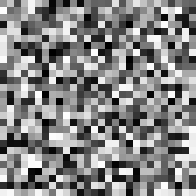
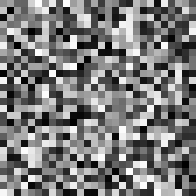
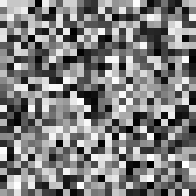
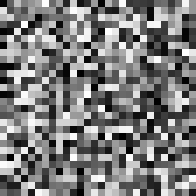
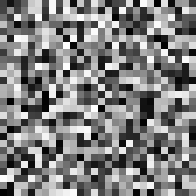
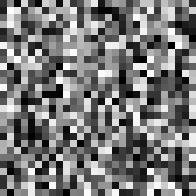
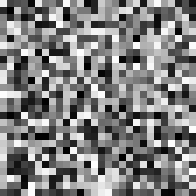
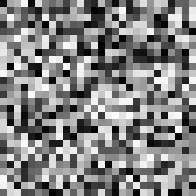
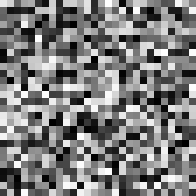
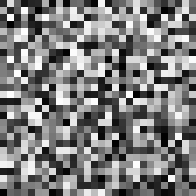
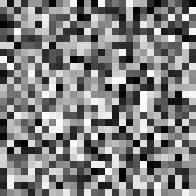
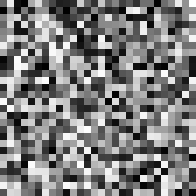
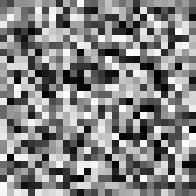
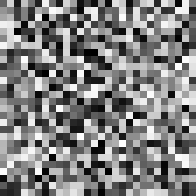
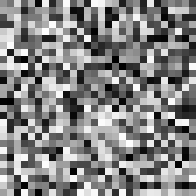
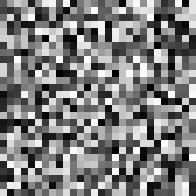
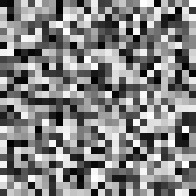
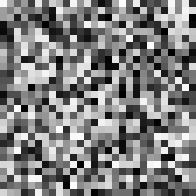
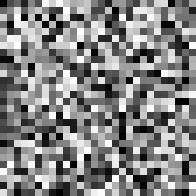
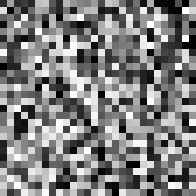
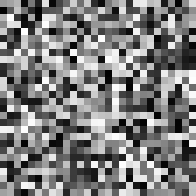
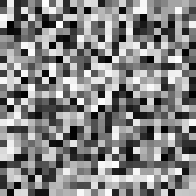
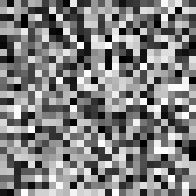
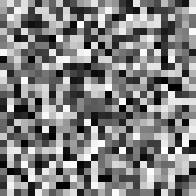
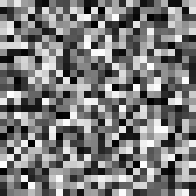
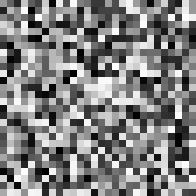
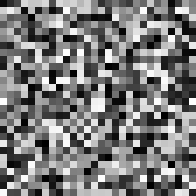
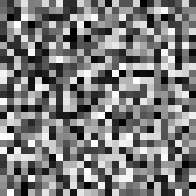
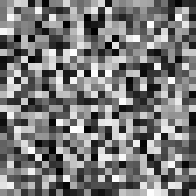
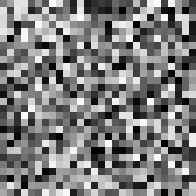
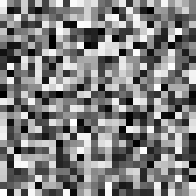
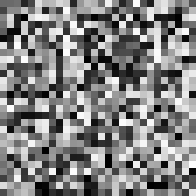
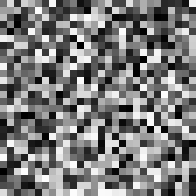
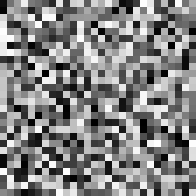
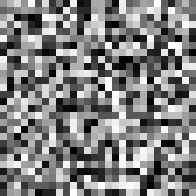
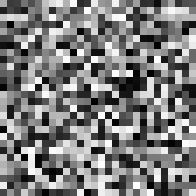
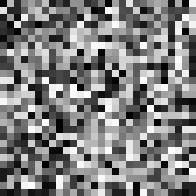
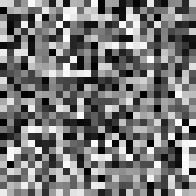
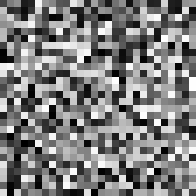
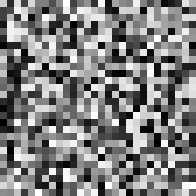
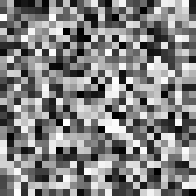
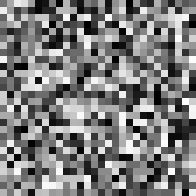
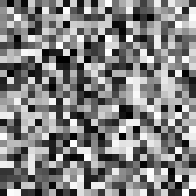
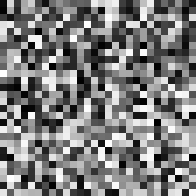
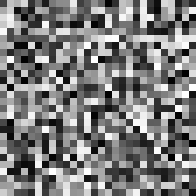
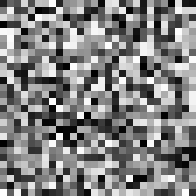
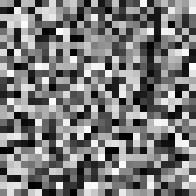
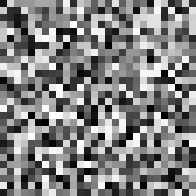
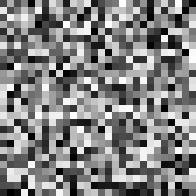
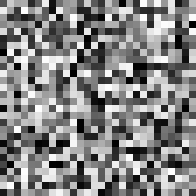
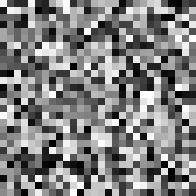
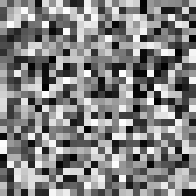
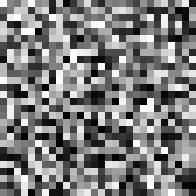
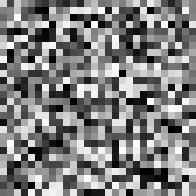
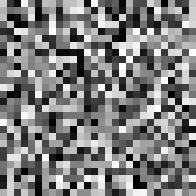
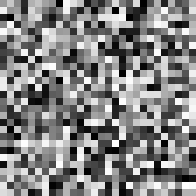
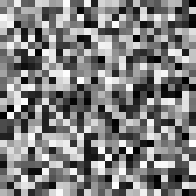
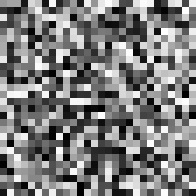
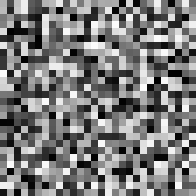
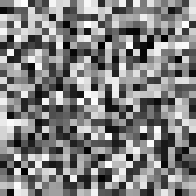
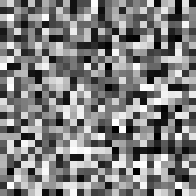
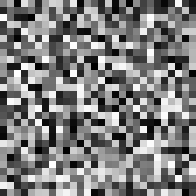
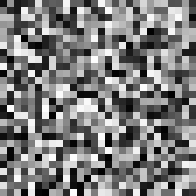
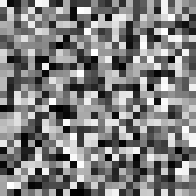
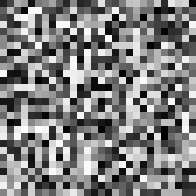
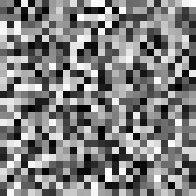
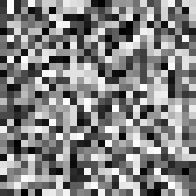
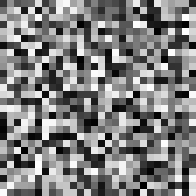
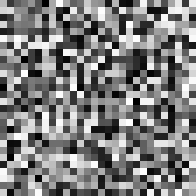
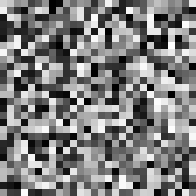
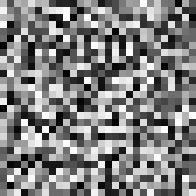
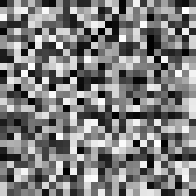
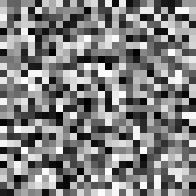
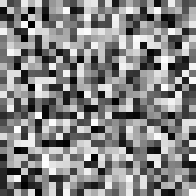
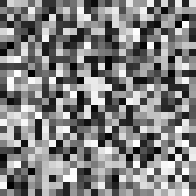
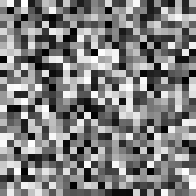
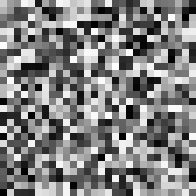
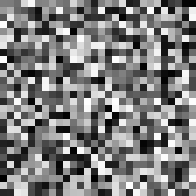
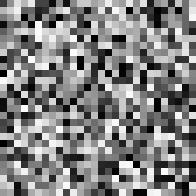
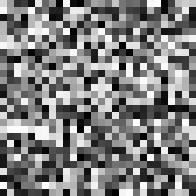
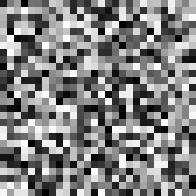
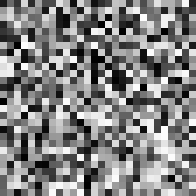
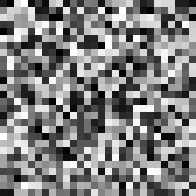
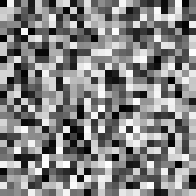
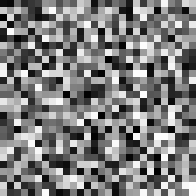
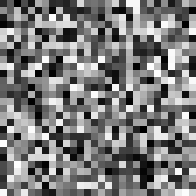
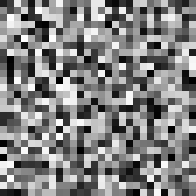
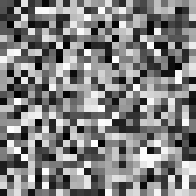
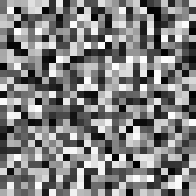
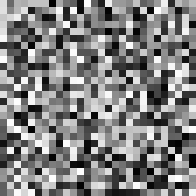
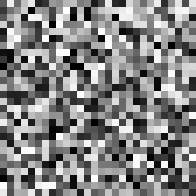
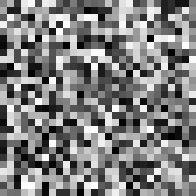
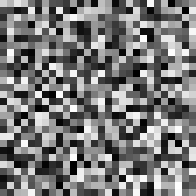
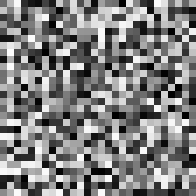
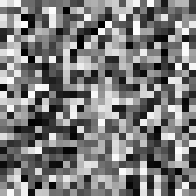
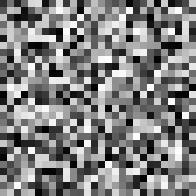
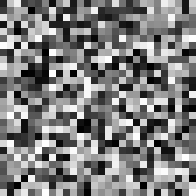
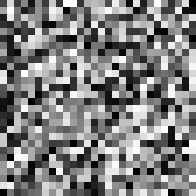
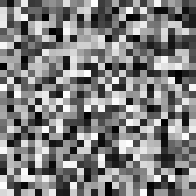

In [3]:
# SOM generic parameters:
shape = (11, 13)
topography = "hex"
borderless = True
input_shape = (28, 28)

som_type = "ksom"

if som_type == "ksom":  # Kohonen
    params = smp.KsomParams(
        t_f=60000, sigma_i=1.0, sigma_f=0.01, alpha_i=0.1, alpha_f=0.001
    )
    model = smp.Ksom(shape, topography, borderless, input_shape, params)

elif som_type == "dsom":  # Dynamic SOM
    params = smp.DsomParams(alpha=0.001, plasticity=0.02)
    model = smp.Dsom(shape, topography, borderless, input_shape, params)

print("Visualisation of the weight values of each node:")
smp.plot(
    model,
    show_prototypes=True,
    show_activity=False,
)

Train the model:


Nb of data samples viewed by the model: 60000


alt.LayerChart(...)
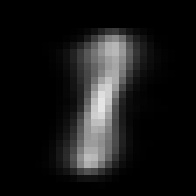
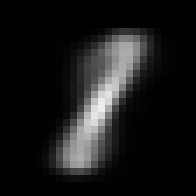
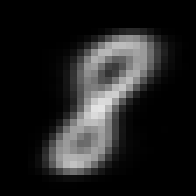
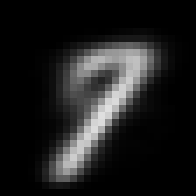
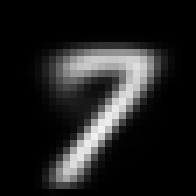
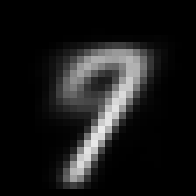
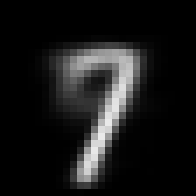
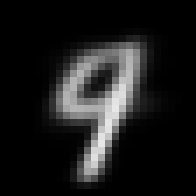
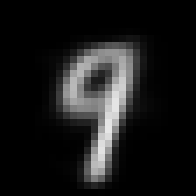
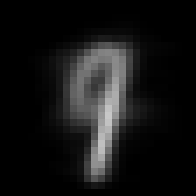
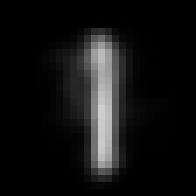
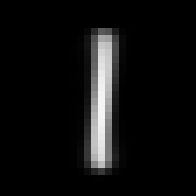
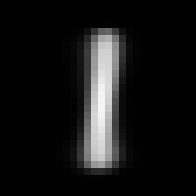
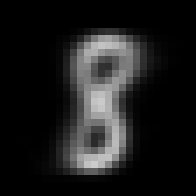
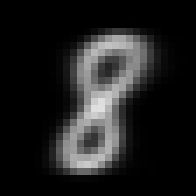
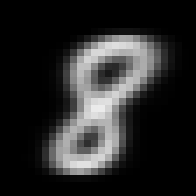
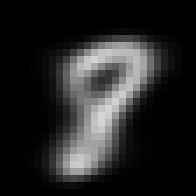
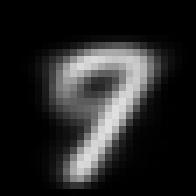
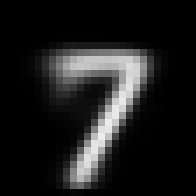
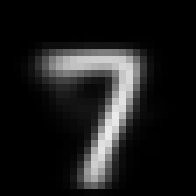
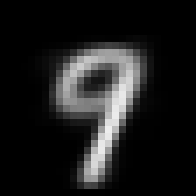
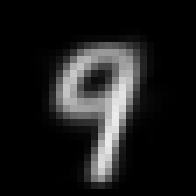
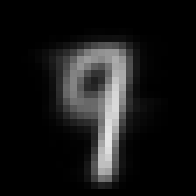
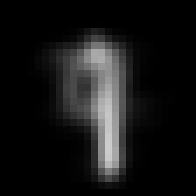
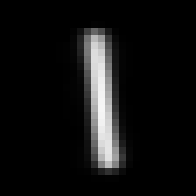
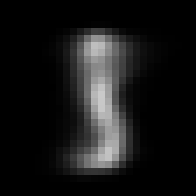
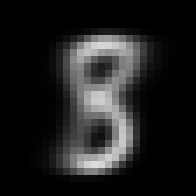
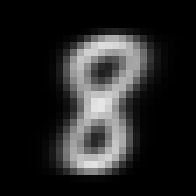
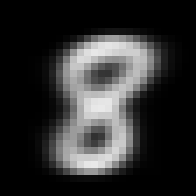
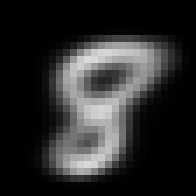
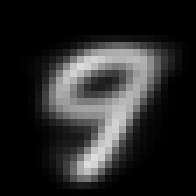
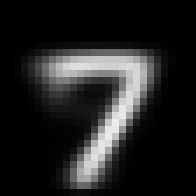
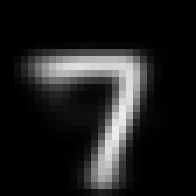
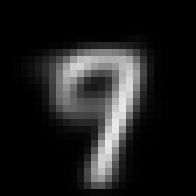
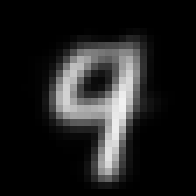
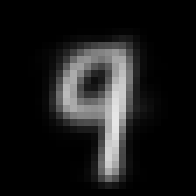
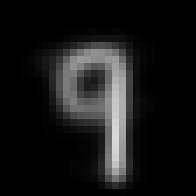
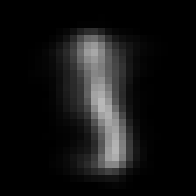
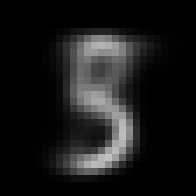
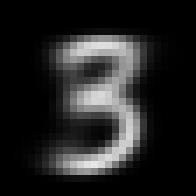
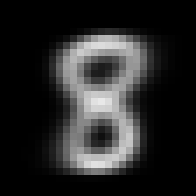
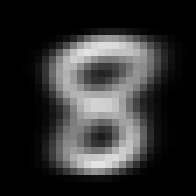
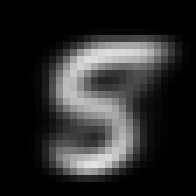
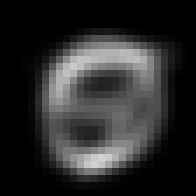
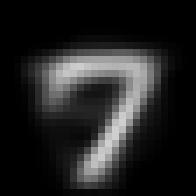
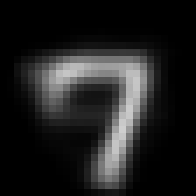
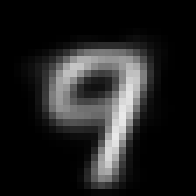
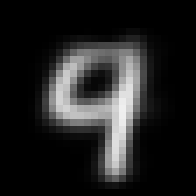
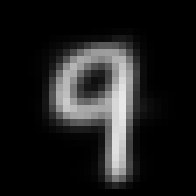
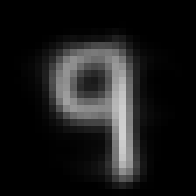
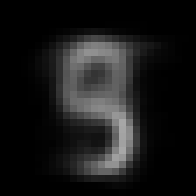
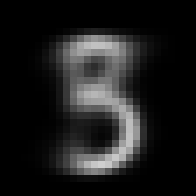
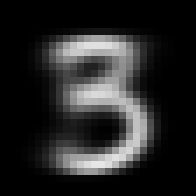
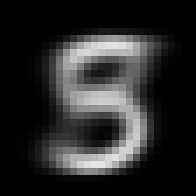
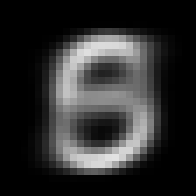
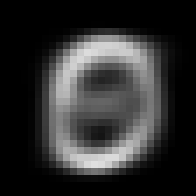
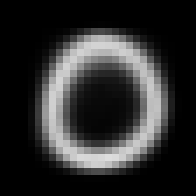
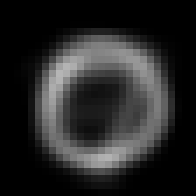
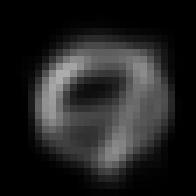
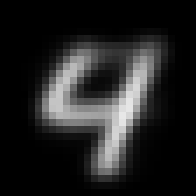
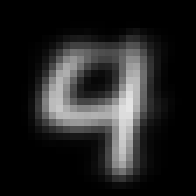
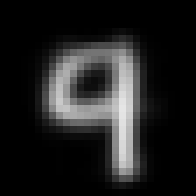
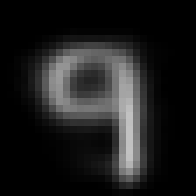
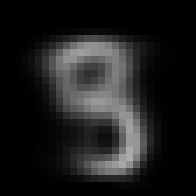
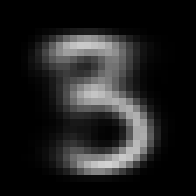
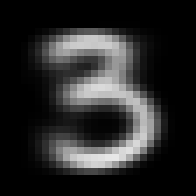
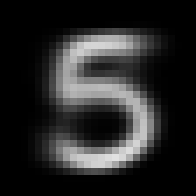
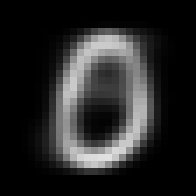
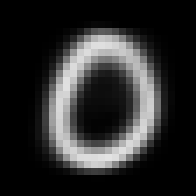
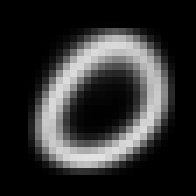
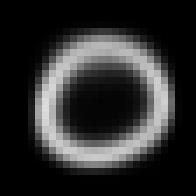
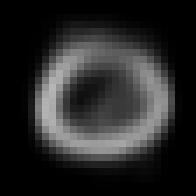
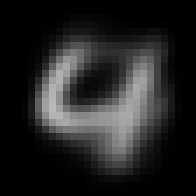
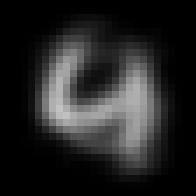
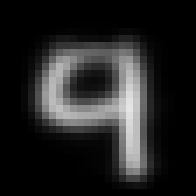
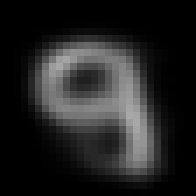
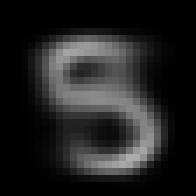
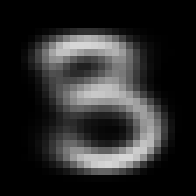
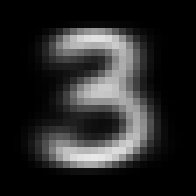
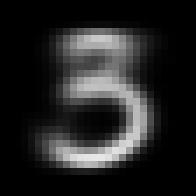
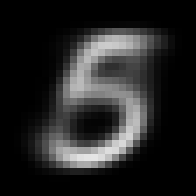
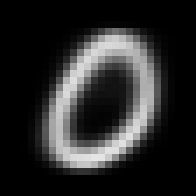
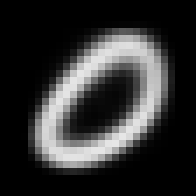
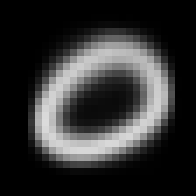
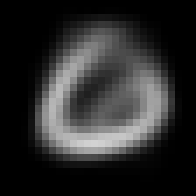
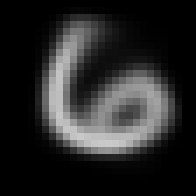
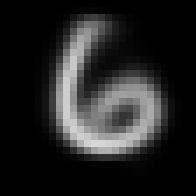
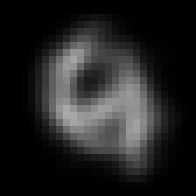
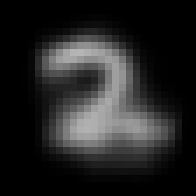
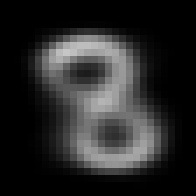
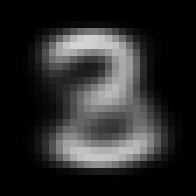
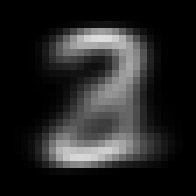
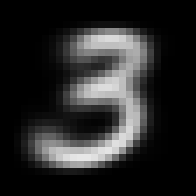
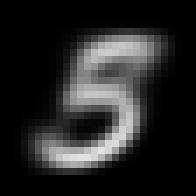
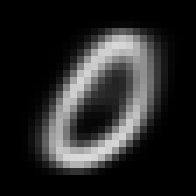
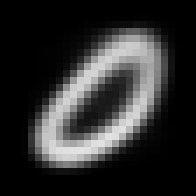
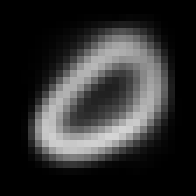
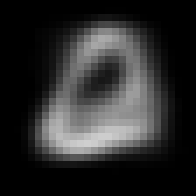
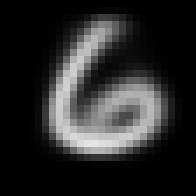
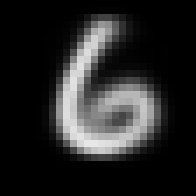
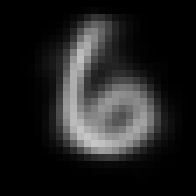
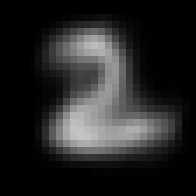
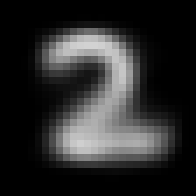
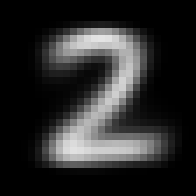
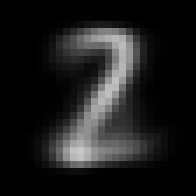
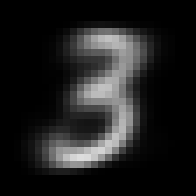
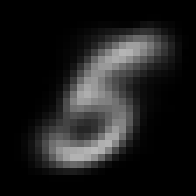
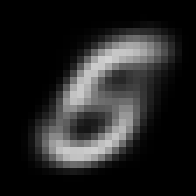
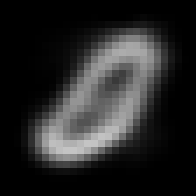
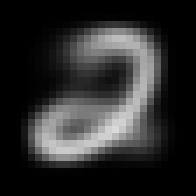
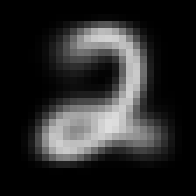
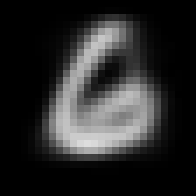
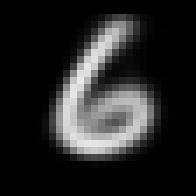
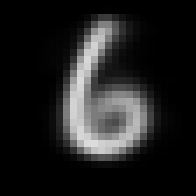
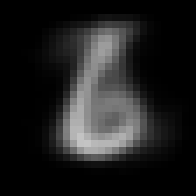
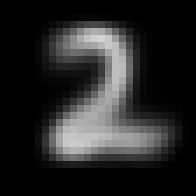
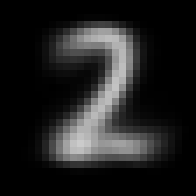
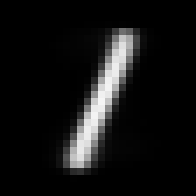
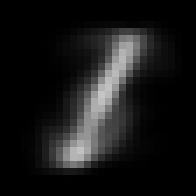
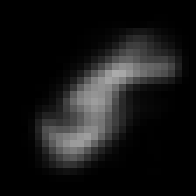
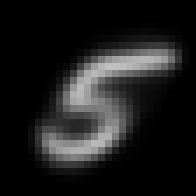
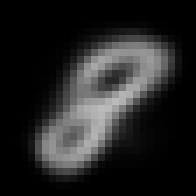
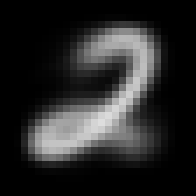
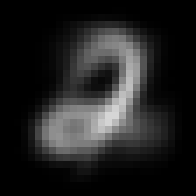
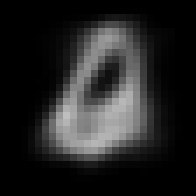
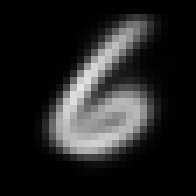
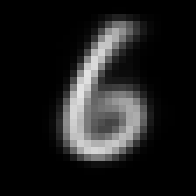
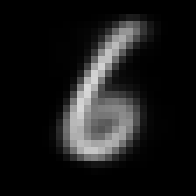
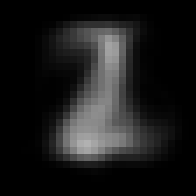
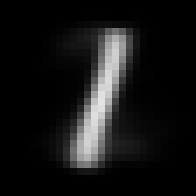
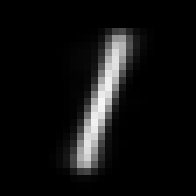
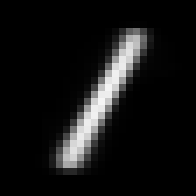
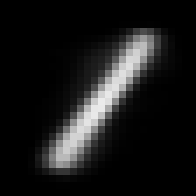
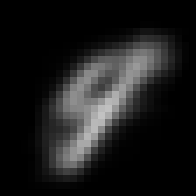
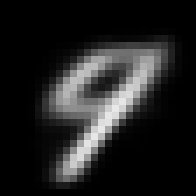
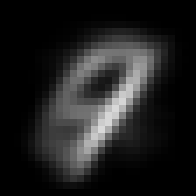
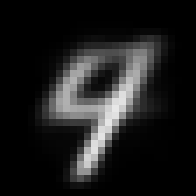
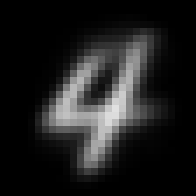
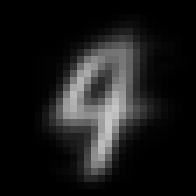
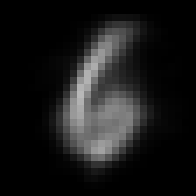
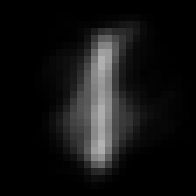
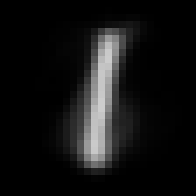
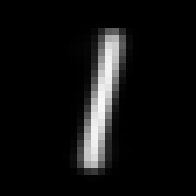

In [4]:
epoch = 1
auxs = []
for i in range(0, epoch):
    model, aux = smp.make_steps(model, {"bu_v": data})
    auxs.append(aux)

# Concatenate the 'aux' outputs if there are several
aux = jax.tree.map(
    lambda x, *y: np.concatenate((x, *y), axis=0),
    *auxs,
    is_leaf=lambda x: isinstance(x, list),
)

print(f"Nb of data samples viewed by the model: {epoch * data.shape[0]}")

smp.plot(model, show_prototypes=True, show_activity=True)

### Evaluation

Show the quantization error:


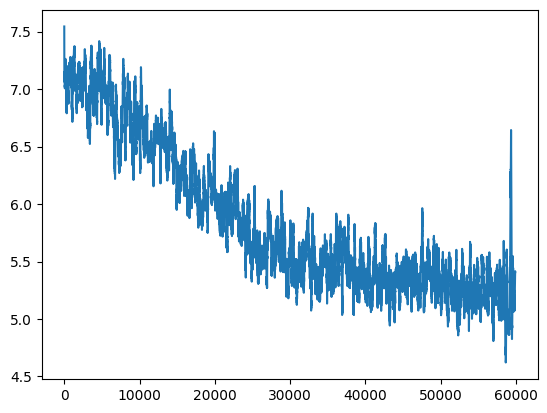

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


errors = aux["metrics"]["quantization_error"]
plt.plot(moving_average(errors, 100))

Show the topographic error:

Note: An error of 1/sqrt(w,h) (where w is the width and h is the height of the map) means that the two best winning nodes are neighbors


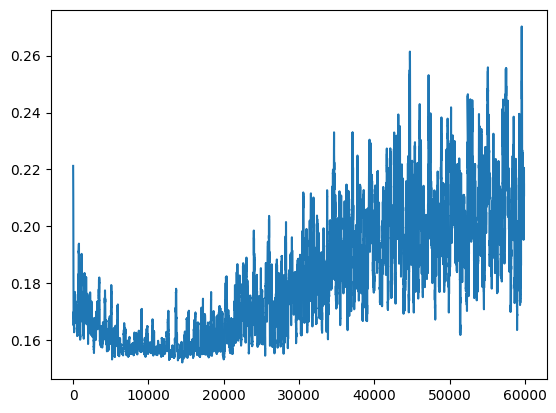

In [6]:
errors = aux["metrics"]["topographic_error"]
plt.plot(moving_average(errors, 100))